In [1]:
import os

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

os.chdir(current_dir_path + '\\ultils')

import pickle
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from tdamapper.core import MapperAlgorithm
from tdamapper.cover import CubicalCover
from tdamapper.plot import MapperLayoutInteractive, MapperLayoutStatic
from tdamapper.clustering import FailSafeClustering
from sklearn import metrics

from functions import *
from chi import *
from regressionP import *
from models import *

In [2]:
data1 = pd.read_csv("../Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("../Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("../Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("../Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("../Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("../Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6], ignore_index=True)

dataA1 = pd.read_csv("../Data/NPA_TMA1_new.csv")[:-2]

In [3]:
def preprocess(input_data, select_lst):
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 7]
    dataA = sample_data[select_lst]

    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df, sample_data

select_lst = [
            # '發生月份', 
            # '天候名稱', '光線名稱',
            # '當事者屬-性-別名稱', '當事者事故發生時年齡', '當事者順位',
            # '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
            # '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱', 
            '號誌-號誌種類名稱', '號誌-號誌動作名稱',
            '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', 
            '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '事故類型及型態大類別名稱', '事故位置大類別名稱',
            # '保護裝備名稱', '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他',
            # '肇因研判大類別名稱-主要', '當事者區分-類別-大類別名稱-車種', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃', '當事者行動狀態大類別名稱', '行動電話或電腦或其他相類功能裝置名稱'
            '經度', '緯度', '死亡受傷人數',
            '道路型態子類別名稱', '事故位置子類別名稱', '事故類型及型態子類別名稱', '車道劃分設施-分向設施子類別名稱'
            # '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-主要', '事故類型及型態子類別名稱', '車道劃分設施-分向設施子類別名稱',
            # '車輛撞擊部位子類別名稱-其他', '當事者區分-類別-子類別名稱-車種', '肇因研判子類別名稱-個別', 
             ]
dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

rbind_data = pd.concat([dist_dfA1[0], dist_dfA2[0]], axis=0, ignore_index=True)
rbind_data['速限-第1當事者'] = rbind_data['速限-第1當事者'].apply(lambda x: 1 if x > 60 else 0)
dummy_data = pd.get_dummies(rbind_data.drop(columns=['經度', '緯度', '死亡', '受傷']))

# rbind_data = rbind_data.drop(columns=['死亡', '受傷'])

In [18]:
pca = PCA(n_components=5)
lens1 = pca.fit_transform(dummy_data.to_numpy())

# 查看每個主成分保留的變異量比例
explained_variance_ratio = pca.explained_variance_ratio_
print(sum(explained_variance_ratio))
print(explained_variance_ratio)

0.6689291139346483
[0.28648672 0.1583327  0.09096597 0.0777441  0.05539963]


In [23]:
start_time = time.time()

lens1 = PCA(5).fit_transform(dummy_data.to_numpy())

mapper_algo1 = MapperAlgorithm(
    cover = CubicalCover(
        n_intervals = 5,
        overlap_frac = 0.5
    ),
    clustering = FailSafeClustering(
        clustering = AgglomerativeClustering(5),
        verbose = False)
)

mapper_graph1 = mapper_algo1.fit_transform(dummy_data.to_numpy(), lens1)

end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

155.12480998039246


In [24]:
mapper_plot1 = MapperLayoutInteractive(
    mapper_graph1,
    colors = dummy_data[['號誌-號誌種類名稱_無號誌']].to_numpy(),
    cmap = 'jet',
    agg = np.nanmean,
    # agg = most_frequent_nonan,
    dim = 3,
    iterations = 30,
    seed = 6,
    width = 800,
    height = 500)

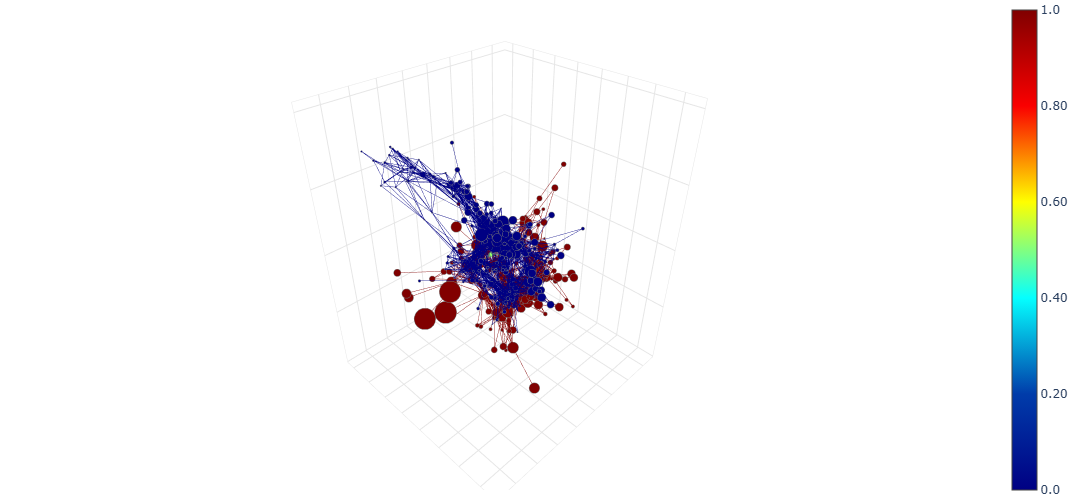

In [25]:
fig_mean1 = mapper_plot1.plot()
fig_mean1.show(config={'scrollZoom': True})

In [12]:
# import pickle

# with open('CalculatedData/道路V2_dummy.pkl', 'wb') as f:
#     pickle.dump(mapper_graph1, f)

# 模型比較

In [26]:
# select_lst = [
#             '號誌-號誌種類名稱', '號誌-號誌動作名稱',
#             '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', 
#             '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '事故類型及型態大類別名稱', '事故位置大類別名稱',
#             '經度', '緯度', '死亡受傷人數',
    
#             '發生月份', 
#             '天候名稱', '光線名稱',
#             '當事者屬-性-別名稱', '當事者事故發生時年齡', '當事者順位',
#             '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
#             '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱', 
    
#             '保護裝備名稱', '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他',
#             '肇因研判大類別名稱-主要', '當事者區分-類別-大類別名稱-車種', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃', '當事者行動狀態大類別名稱', '行動電話或電腦或其他相類功能裝置名稱',
#             '道路型態子類別名稱', '事故位置子類別名稱', '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-主要', '事故類型及型態子類別名稱', '車道劃分設施-分向設施子類別名稱',
#             '車輛撞擊部位子類別名稱-其他', '當事者區分-類別-子類別名稱-車種', '肇因研判子類別名稱-個別', 
#              ]
select_lst = [
            # '發生月份', 
            # '天候名稱', '光線名稱',
            # '當事者屬-性-別名稱', '當事者事故發生時年齡',
            '當事者順位',
            # '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
            # '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱', 
            '號誌-號誌種類名稱', '號誌-號誌動作名稱',
            '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', 
            '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '事故類型及型態大類別名稱', '事故位置大類別名稱',
            # '保護裝備名稱', '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他',
            # '肇因研判大類別名稱-主要', '當事者區分-類別-大類別名稱-車種', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃', '當事者行動狀態大類別名稱', '行動電話或電腦或其他相類功能裝置名稱'
            '經度', '緯度', '死亡受傷人數',
            # '道路型態子類別名稱', '事故位置子類別名稱', '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-主要', '事故類型及型態子類別名稱', '車道劃分設施-分向設施子類別名稱',
            # '車輛撞擊部位子類別名稱-其他', '當事者區分-類別-子類別名稱-車種', '肇因研判子類別名稱-個別', 
             ]

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

rbind_data = pd.concat([dist_dfA1[0], dist_dfA2[0]], axis=0, ignore_index=True)
rbind_data['速限-第1當事者'] = rbind_data['速限-第1當事者'].apply(lambda x: 1 if x > 60 else 0)
# dummy_data = pd.get_dummies(rbind_data.drop(columns=['經度', '緯度', '死亡', '受傷']))
dummy_data = pd.get_dummies(rbind_data.drop(columns=['經度', '緯度', '受傷', '當事者順位']))

merged_df = pd.concat([dist_dfA1[0][['死亡', '受傷']], dist_dfA2[0][['死亡', '受傷']]], axis=0)

In [28]:
# with open('CalculatedData/道路V2_dummy.pkl', 'rb') as f:
#     mapper_graph1 = pickle.load(f)
    
# mapper_plot1 = MapperLayoutInteractive(
#     mapper_graph1,
#     colors = dummy_data[['號誌-號誌種類名稱_無號誌']].to_numpy(),
#     cmap = 'jet',
#     # agg = most_frequent_nonan,
#     agg = np.mean,
#     dim = 3,
#     iterations = 30,
#     seed = 6,
#     width = 800,
#     height = 500)

# fig_mean1 = mapper_plot1.plot()
# fig_mean1.show(config={'scrollZoom': True})

In [29]:
x = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['x']
y = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['y']
z = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['z']

threeDimData = pd.DataFrame({'x': x, 'y': y, 'z': z})

import re
data_tuple = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['text']

data = []
for item in data_tuple:
    color = int(re.search(r'color: (-?\d+)', item).group(1))
    node = int(re.search(r'node: (\d+)', item).group(1))
    size = int(re.search(r'size: (\d+)', item).group(1))
    data.append({'color': color, 'node': node, 'size': size})
component_info = pd.DataFrame(data)

full_info = pd.concat([component_info, threeDimData], axis=1)

mp_content_origin = vars(mapper_plot1._MapperLayoutInteractive__graph)['_node']

mp_content = pd.DataFrame.from_dict(mp_content_origin, orient='index')
mp_content.reset_index(inplace=True)
mp_content.rename(columns={'index': 'node'}, inplace=True)

full_info = pd.merge(full_info, mp_content, on=['node', 'size'], how='inner')

In [30]:
# ids_list = full_info[full_info['node'] == 31]['ids'].values[0]
# full_info = full_info[full_info['node'] !=31]
# special_data = rbind_data.iloc[ids_list]

2


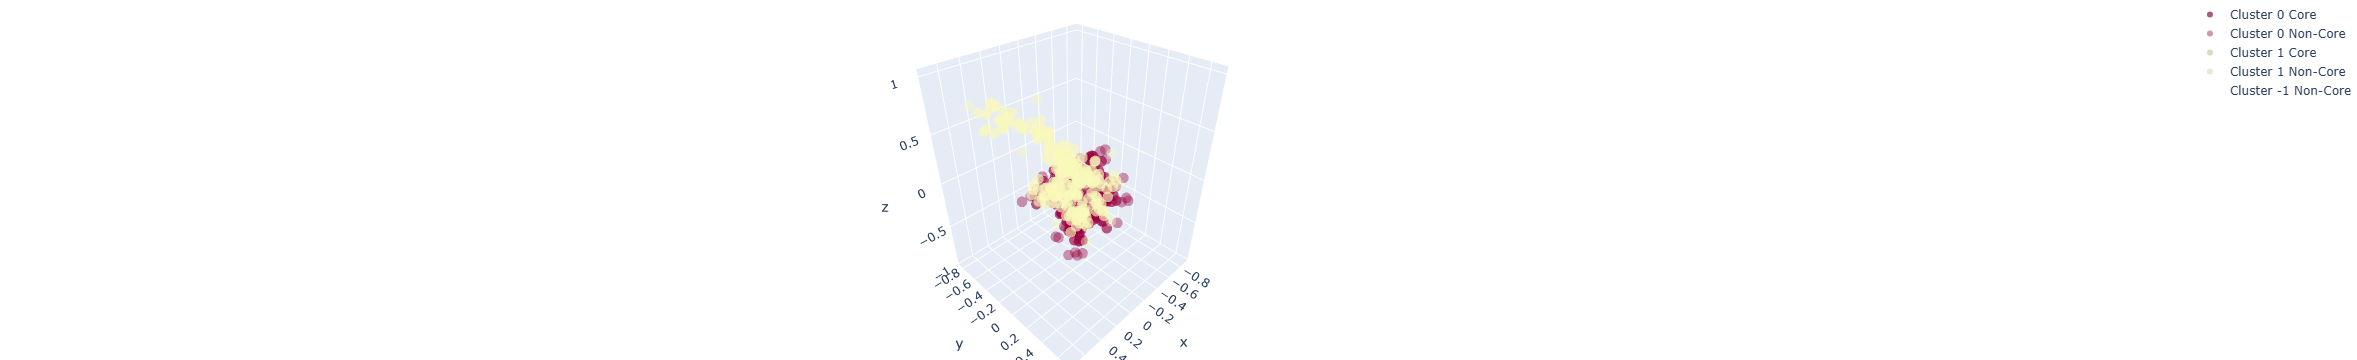

In [36]:
calinski_data = get_calinski_from_db(full_info, 0.19)
labels = calinski_data[3]
db = calinski_data[2]
n_clusters_ = calinski_data[4]

print(n_clusters_)

do_plot(full_info, calinski_data, labels, db, n_clusters_)

In [37]:
label_0 = full_info[full_info['label'] == 0]
label_1 = full_info[full_info['label'] == 1]
label_out = full_info[(full_info['label'] != 1) & (full_info['label'] != 0)]

count_0 = get_count_dict(label_0)
count_1 = get_count_dict(label_1)
count_out = get_count_dict(label_out)

full_0 = dummy_data.loc[count_0.keys()]
full_1 = dummy_data.loc[count_1.keys()]
# 離群值不需要被處理
full_out = dummy_data.loc[count_out.keys()]
lst01 = list(count_0.keys() & count_1.keys())
lsto0 = list(count_out.keys() & count_0.keys())
lsto1 = list(count_out.keys() & count_1.keys())
# Node
full_01 = full_0.loc[lst01]

full_combine = pd.concat([full_01], axis=0)
full_combine = full_combine.reset_index()
full_combine = full_combine.drop_duplicates(subset='index', keep='first')
full_combine = full_combine.drop('index', axis=1)
# 去掉連接點，使分析更嚴謹
full_0 = full_0.drop(lst01 + lsto0, errors='ignore')
full_1 = full_1.drop(lst01 + lsto1, errors='ignore')

print('01連接點數量', len(lst01))
print('o0連接點數量', len(lsto0))
print('o1連接點數量', len(lsto1))
print('離群值數量', full_out.shape[0])

full_combine.shape[0] + full_0.shape[0] + full_1.shape[0] + full_out.shape[0] == dummy_data.shape[0]

01連接點數量 1609
o0連接點數量 12384
o1連接點數量 652
離群值數量 29843


True

In [38]:
def get_clusterN_logit(cluster_data, lst):
    
    scaler = StandardScaler()
    # cluster_data['當事者事故發生時年齡'] = scaler.fit_transform(cluster_data[['當事者事故發生時年齡']])
    
    c0_for_lm_y = cluster_data.apply(lambda row: 1 if row['死亡'] != 0 else 2, axis=1).reset_index(drop=True)
    cluster_data = cluster_data.drop(columns=['死亡'])
    
    return cluster_data, c0_for_lm_y

full_combine_X, full_combine_y = get_clusterN_logit(full_combine, select_lst)
full_0_X, full_0_y = get_clusterN_logit(full_0, select_lst)
full_1_X, full_1_y = get_clusterN_logit(full_1, select_lst)
full_out_X, full_out_y = get_clusterN_logit(full_out, select_lst)

print(full_combine_y.value_counts())
print(full_out_y.value_counts())
print(full_0_y.value_counts())
print(full_1_y.value_counts())

2    1606
1       3
dtype: int64
2    29763
1       80
dtype: int64
2    80951
1      478
dtype: int64
2    76896
1      225
dtype: int64


In [39]:
pca = PCA(n_components=20)
full_combine_X = pca.fit_transform(full_combine_X)
full_out_X = pca.fit_transform(full_out_X)
full_0_X = pca.fit_transform(full_0_X)
full_1_X = pca.fit_transform(full_1_X)

In [202]:
# start_time = time.time()
# matrix_combine, score_combine, cm_combine = logistic_cm_gridsearch(full_combine_X, full_combine_y)
# matrix_out, score_out, cm_out = logistic_cm_gridsearch(full_out_X, full_out_y)
# print(score_combine, score_out)
# end_time = time.time()
# elapsed_time = end_time - start_time
# print(elapsed_time)

In [211]:
matrix_out, score_out, cm_out = logistic_cm_gridsearch(full_out_X, full_out_y)

In [212]:
matrix_out

,Label,Precision,Recall,F1 Score
0,Class_0,0.705882,0.444444,0.545455
1,Class_1,0.594595,0.814815,0.687500


In [40]:
start_time = time.time()
matrix_out, score_out, cm_out = logistic_cm_gridsearch(full_out_X, full_out_y)
print('0')
matrix_0, score_0, cm_0 = logistic_cm_gridsearch(full_0_X, full_0_y)
print('0')
matrix_1, score_1, cm_1 = logistic_cm_gridsearch(full_1_X, full_1_y)
print('1')

print(score_0, score_1, score_out)
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

0
0
1
0.673202614379085 0.6554054054054054 0.6363636363636364
749.2924063205719


In [43]:
matrix_out

,Label,Precision,Recall,F1 Score
0,Class_0,0.736842,0.424242,0.538462
1,Class_1,0.595745,0.848485,0.700000


In [41]:
matrix_0

,Label,Precision,Recall,F1 Score
0,Class_0,0.705426,0.594771,0.64539
1,Class_1,0.649718,0.751634,0.69697


In [42]:
matrix_1

,Label,Precision,Recall,F1 Score
0,Class_0,0.709091,0.527027,0.604651
1,Class_1,0.623656,0.783784,0.694611


In [45]:
cm_0_1 = cm_0 + cm_1 + cm_out

TP = cm_0_1[0][0]
FP = cm_0_1[0][1]
FN = cm_0_1[1][0]
TN = cm_0_1[1][1]

# Re-calculating accuracy
accuracy_given_cm = (TP + TN) / (TP + TN + FP + FN)
accuracy_given_cm

0.6634615384615384

In [47]:
cm_0_1

array([[144, 116],
       [ 59, 201]], dtype=int64)

In [46]:
y_true = [0] * (TP + FP) + [1] * (FN + TN)
y_pred = [0] * TP + [1] * FP + [0] * FN + [1] * TN

# Calculating the precision, recall, f1 score and accuracy using scikit-learn
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Label': [f'Class_{i}' for i in range(len(precision))],
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

metrics_df

,Label,Precision,Recall,F1 Score
0,Class_0,0.709360,0.553846,0.622030
1,Class_1,0.634069,0.773077,0.696707


In [219]:
full_X, full_y = get_clusterN_logit(dummy_data, select_lst)
full_X.head()

,速限-第1當事者,號誌-號誌種類名稱_無號誌,號誌-號誌種類名稱_行車管制號誌,號誌-號誌種類名稱_行車管制號誌(附設行人專用號誌),號誌-號誌種類名稱_閃光號誌,號誌-號誌動作名稱_不正常,號誌-號誌動作名稱_正常,號誌-號誌動作名稱_無動作,號誌-號誌動作名稱_無號誌,車道劃分設施-分向設施大類別名稱_中央分向島,...,道路型態大類別名稱_圓環廣場,道路型態大類別名稱_平交道,事故類型及型態大類別名稱_人與車,事故類型及型態大類別名稱_平交道事故,事故類型及型態大類別名稱_車與車,事故類型及型態大類別名稱_車輛本身,事故位置大類別名稱_交叉路口,事故位置大類別名稱_交流道,事故位置大類別名稱_其他,事故位置大類別名稱_路段
0,0,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,1,0
1,0,0,0,0,1,0,1,0,0,1,...,0,0,0,0,1,0,1,0,0,0
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1


In [220]:
full_X = pca.fit_transform(full_X)
matrix, score, cm = logistic_cm_gridsearch(full_X, full_y)
score

0.7

In [221]:
matrix

,Label,Precision,Recall,F1 Score
0,Class_0,0.704762,0.688372,0.696471
1,Class_1,0.695455,0.711628,0.703448


# 顯著特徵

In [49]:
def table(colnames, full_0, full_1):
    
    combined_df = pd.concat([full_0[colnames].value_counts(normalize = True), 
                             full_1[colnames].value_counts(normalize = True)
                            ],
                            axis=1).fillna(0)

    combined_df.columns = ['A', 'B']
    
    return combined_df

In [53]:
# for i in full_0.columns:
#     print(table(i, full_0, full_1))

In [82]:
# X, y, p = pval(full_0, full_1, [x for x in full_1.columns if x not in ['受傷', '死亡']])
# p